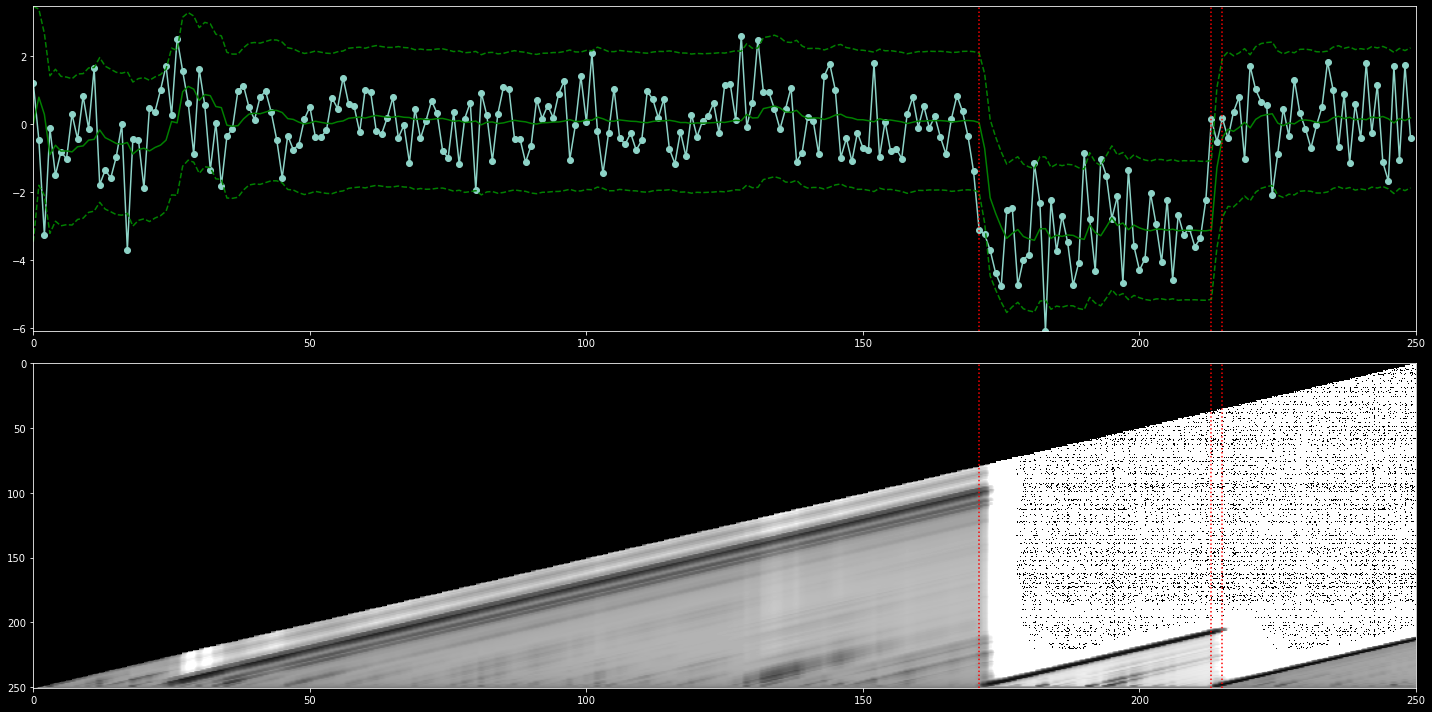

In [96]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import numpy as np
from   scipy.stats import norm
from   scipy.special import logsumexp
plt.style.use('dark_background')


# -----------------------------------------------------------------------------

def bocd(data, model, hazard):
    """Return run length posterior using Algorithm 1 in Adams & MacKay 2007.
    """
    # 1. Initialize lower triangular matrix representing the posterior as
    #    function of time. Model parameters are initialized in the model class.
    #    
    #    When we exponentiate R at the end, exp(-inf) --> 0, which is nice for
    #    visualization.
    #
    T           = len(data)
    log_R       = -np.inf * np.ones((T+1, T+1))
    log_R[0, 0] = 0              # log 0 == 1
    pmean       = np.empty(T)    # Model's predictive mean.
    pvar        = np.empty(T)    # Model's predictive variance. 
    log_message = np.array([0])  # log 0 == 1
    log_H       = np.log(hazard)
    log_1mH     = np.log(1 - hazard)

    for t in range(1, T+1):
        # 2. Observe new datum.
        x = data[t-1]

        # Make model predictions.
        pmean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * model.mean_params[:t])
        pvar[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * model.var_params[:t])
        
        # 3. Evaluate predictive probabilities.
        log_pis = model.log_pred_prob(t, x)

        # 4. Calculate growth probabilities.
        log_growth_probs = log_pis + log_message + log_1mH

        # 5. Calculate changepoint probabilities.
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # 6. Calculate evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        # 7. Determine run length distribution.
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # 8. Update sufficient statistics.
        model.update_params(t, x)

        # Pass message.
        log_message = new_log_joint

    R = np.exp(log_R)
    return R, pmean, pvar


# -----------------------------------------------------------------------------


class GaussianUnknownMean:
    
    def __init__(self, mean0, var0, varx):
        """Initialize model.
        
        meanx is unknown; varx is known
        p(meanx) = N(mean0, var0)
        p(x) = N(meanx, varx)
        """
        self.mean0 = mean0
        self.var0  = var0
        self.varx  = varx
        self.mean_params = np.array([mean0])
        self.prec_params = np.array([1/var0])
    
    def log_pred_prob(self, t, x):
        """Compute predictive probabilities \pi, i.e. the posterior predictive
        for each run length hypothesis.
        """
        # Posterior predictive: see eq. 40 in (Murphy 2007).
        post_means = self.mean_params[:t]
        post_stds  = np.sqrt(self.var_params[:t])
        return norm(post_means, post_stds).logpdf(x)
    
    def update_params(self, t, x):
        """Upon observing a new datum x at time t, update all run length 
        hypotheses.
        """
        # See eq. 19 in (Murphy 2007).
        new_prec_params  = self.prec_params + (1/self.varx)
        self.prec_params = np.append([1/self.var0], new_prec_params)
        # See eq. 24 in (Murphy 2007).
        new_mean_params  = (self.mean_params * self.prec_params[:-1] + \
                            (x / self.varx)) / new_prec_params
        self.mean_params = np.append([self.mean0], new_mean_params)

    @property
    def var_params(self):
        """Helper function for computing the posterior variance.
        """
        return 1./self.prec_params + self.varx

# -----------------------------------------------------------------------------

def generate_data(varx, mean0, var0, T, cp_prob):
    """Generate partitioned data of T observations according to constant
    changepoint probability `cp_prob` with hyperpriors `mean0` and `prec0`.
    """
    data  = []
    cps   = []
    meanx = mean0
    for t in range(0, T):
        if np.random.random() < cp_prob:
            meanx = np.random.normal(mean0, var0)
            cps.append(t)
        data.append(np.random.normal(meanx, varx))
    return data, cps


# -----------------------------------------------------------------------------

def plot_posterior(T, data, cps, R, pmean, pvar):
    fig, axes = plt.subplots(2, 1, figsize=(20,10))

    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)
    
    # Plot predictions.
    ax1.plot(range(0, T), pmean, c='g')
    _2std = 2 * np.sqrt(pvar)
    ax1.plot(range(0, T), pmean - _2std, c='g', ls='--')
    ax1.plot(range(0, T), pmean + _2std, c='g', ls='--')

    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
    ax2.set_xlim([0, T])
    ax2.margins(0)

    for cp in cps:
        ax1.axvline(cp, c='red', ls='dotted')
        ax2.axvline(cp, c='red', ls='dotted')

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------

T      = 250   # Number of observations.
hazard = 1/100  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps      = generate_data(varx, mean0, var0, T, hazard)
model          = GaussianUnknownMean(mean0, var0, varx)
R, pmean, pvar = bocd(data, model, hazard)

plot_posterior(T, data, cps, R, pmean, pvar)

In [50]:
from scipy import stats

In [51]:
class Hazard:
    def __call__(self, *args, **kwargs):
        raise NotImplementedError()


class ConstantHazard(Hazard):
    def __init__(self, _lambda):
        self._lambda = _lambda

    def __call__(self, r):
        """
        Args:
          r: The length of the current run (np.ndarray or scalar)

        Returns:
          p: Changepoint Probabilities(np.ndarray with shape = r.shape)
        """
        if isinstance(r, np.ndarray):
            shape = r.shape
        else:
            shape = 1

        return np.ones(shape) / self._lambda

In [52]:

class Distribution:
    def reset_params(self):
        raise NotImplementedError()

    def pdf(self, x):
        raise NotImplementedError()

    def update_params(self, x):
        raise NotImplementedError()


class StudentT(Distribution):
    """ Generalized Student t distribution 
    https://en.wikipedia.org/wiki/Student%27s_t-distribution#Generalized_Student's_t-distribution

    This setting corresponds to select
      1: Gaussian distribution as a likelihood
      2: normal-Gamma distribution as a prior for Gaussian
    """

    def __init__(self, mu=0, kappa=1, alpha=1, beta=1):
        self.mu0 = np.array([mu])
        self.kappa0 = np.array([kappa])
        self.alpha0 = np.array([alpha])
        self.beta0 = np.array([beta])
        # We need the following lines to prevent "outside defined warning"
        self.muT = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT = self.beta0.copy()

    def reset_params(self):
        self.muT = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT = self.beta0.copy()

    def pdf(self, x):
        """ Probability Density Function
        """
        return stats.t.pdf(
            x,
            loc=self.muT,
            df=2 * self.alphaT,
            scale=np.sqrt(self.betaT * (self.kappaT + 1) / (self.alphaT * self.kappaT)),
        )

    def update_params(self, x):
        """Update Sufficient Statistcs (Parameters)

        To understand why we use this, see e.g.
        Conjugate Bayesian analysis of the Gaussian distribution, Kevin P. Murphy∗
        https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
        3.5 Posterior predictive
        """       
        self.betaT = np.concatenate(
            [
                self.beta0,
                (self.kappaT + (self.kappaT * (x - self.muT) ** 2) / (2 * (self.kappaT + 1))),
            ]
        )
        self.muT = np.concatenate([self.mu0, (self.kappaT * self.muT + x) / (self.kappaT + 1)])
        self.kappaT = np.concatenate([self.kappa0, self.kappaT + 1])
        self.alphaT = np.concatenate([self.alpha0, self.alphaT + 0.5])
        

In [75]:
class BayesianOnlineChangePointDetection:
    def __init__(self, hazard, distribution):
        self.hazard = hazard
        self.distribution = distribution
        self.T = 0
        self.beliefs = np.zeros((1, 2))
        self.beliefs[0, 0] = 1.0
        
        self.counter = 0

    def reset_params(self):
        self.T = 0
        self.beliefs = np.zeros((1, 2))
        self.beliefs[0, 0] = 1.0

    def _expand_belief_matrix(self):
        rows = np.zeros((1, 2))
        self.beliefs = np.concatenate((self.beliefs, rows), axis=0)

    def _shift_belief_matrix(self):
        self.beliefs[:, 0] = self.beliefs[:, 1]
        self.beliefs[:, 1] = 0.0

    def update(self, x):

        self._expand_belief_matrix()


        # Evaluate Predictive Probability (3 in Algortihm 1)

        pi_t = self.distribution.pdf(x)

        # Calculate H(r_{t-1})
        h = self.hazard(self.rt)

        # Calculate Growth Probability (4 in Algorithm 1)
        self.beliefs[1 : self.T + 2, 1] = self.beliefs[: self.T + 1, 0] * pi_t * (1 - h)

        # Calculate Changepoint Probabilities (5 in Algorithm 1)
        self.beliefs[0, 1] = (self.beliefs[: self.T + 1, 0] * pi_t * h).sum()

        # Determine Run length Distribution (7 in Algorithm 1)
        self.beliefs[:, 1] = self.beliefs[:, 1] / self.beliefs[:, 1].sum()

        # Update sufficient statistics (8 in Algorithm 8)
        self.distribution.update_params(x)

        # Update internal state
        self._shift_belief_matrix()
        self.T += 1
        


    @property
    def rt(self):
        return np.where(self.beliefs[:, 0] == self.beliefs[:, 0].max())[0]

    @property
    def belief(self):
        return self.beliefs[:, 0]        

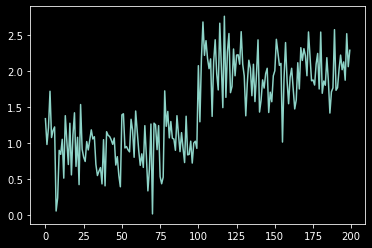

In [89]:
# Generate test data
test_signal = np.concatenate(
    [np.random.normal(0.7, 0.1, 300), 
     np.random.normal(1.5, 0.05, 300),
     np.random.normal(0.6, 0.01, 300),
     np.random.normal(1.3, 0.2, 300)])

m = 1
v = 0.1
n = 100
x = np.random.normal(m, np.sqrt(v), n)
m = 2
x = np.hstack((x,np.random.normal(m, np.sqrt(v), n)))
test_signal = x

plt.plot(test_signal)
plt.show()



# Initialize object
bc = BayesianOnlineChangePointDetection(
    ConstantHazard(100), 
    StudentT(mu=0, kappa=1, alpha=1, beta=1)
    )

# Online estimation and get the maximum likelihood r_t at each time point
rt_mle = np.empty(test_signal.shape)
for i, d in enumerate(test_signal):
    bc.update(d)
    rt_mle[i] = bc.rt 

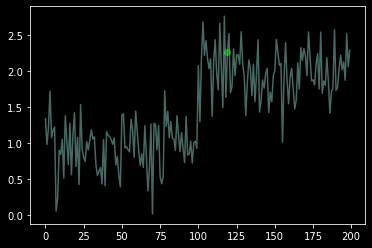

In [90]:
# Plot data with estimated change points
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(np.diff(rt_mle)<0)[0]
plt.scatter(index_changes, test_signal[index_changes], c='green', label="change point")

In [91]:
rt_mle

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  5